### Importing required libraries

In [12]:
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import cross_validation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV


### Utilities

In [2]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    
    
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Importing data

In [6]:
# finn's data set 
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 115


In [40]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
data_ext = np.concatenate((data['rest_1_mat'],data2['rest_1_mat']),axis=2)
gF = np.concatenate((gF,gF2))
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 435


In [32]:
#data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

### gF score distribution 
The gF score is used to divide subjects in 2 or 3 classes.

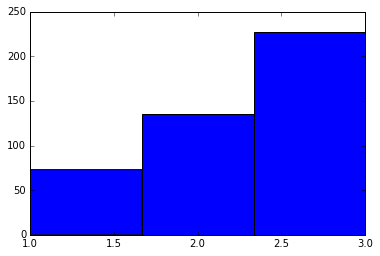

In [43]:
n_bins = 3

# needed for stratified k-fold
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
plt.hist(bins,n_bins)
plt.show()

### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

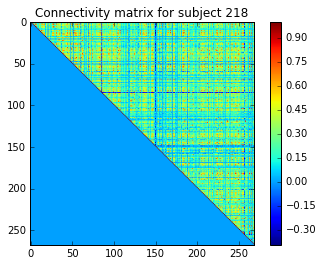

In [42]:
# choose dataset
#conn_mats = data['rest_1_mat']
#conn_mats = data['rest_2_mat']
conn_mats = data_ext

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj))    
    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

### Tests
Instead of performing regression in this experiment we try to divide subjects in 2 or 3 classes according to their gF score.

When performing PCA, select the number of components such that the amount of variance that needs to be explained is greater than 99.9%.

In [44]:
# Test with all edges (PCA in CV)
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
#estimator =LinearSVC(random_state=0)
estimator = SVC(kernel='linear',probability=True,random_state=42)
pca = PCA(n_components=0.999)
prob = np.zeros([n_subj,n_bins])
i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    # decomposition
    data_pc = pca.fit_transform(edges[train_index,])
    # regression
    estimator.fit(data_pc,bins[train_index])
    predictions[i] = estimator.predict(pca.transform(edges[test_index,]))
    prob[i,] = estimator.predict_proba(pca.transform(edges[test_index,]))
    errors[i] = 1 if predictions[i]==bins[test_index] else 0
    i += 1
    f.value += 1
        
print('Accuracy:',errors.mean())
preds_ext_3 = predictions


Accuracy: 0.473563218391


In [10]:
print(np.transpose(preds_finn))

[[ 1.  2.  1.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   1.  2.  1.  1.  2.  2.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.
   1.  2.  1.  2.  1.  2.  1.  2.  1.  2.  2.  2.  2.  1.  2.  1.  2.  2.
   2.  2.  1.  2.  2.  2.  2.  2.  1.  2.  1.  1.  2.  2.  2.  2.  2.  2.
   2.  1.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  1.  2.  2.
   2.  2.  2.  2.  2.  2.  2.]]


In [24]:
print(np.transpose(preds_rest_1)) # 3 classes

[[ 2.  3.  2.  3.  1.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  2.  3.  3.
   3.  3.  3.  3.  3.  3.  2.  3.  3.  3.  3.  3.  3.  3.  2.  3.  3.  3.
   3.  2.  3.  3.  3.  3.  2.  1.  3.  3.  3.  3.  3.  2.  3.  2.  3.  3.
   3.  1.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  2.  2.  3.  2.  3.  2.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  2.  3.  3.  2.  3.  3.  3.
   3.  3.  3.  2.  3.  3.  3.  3.  3.  3.  3.  2.  3.  2.  3.  3.  3.  2.
   3.  3.  3.  3.  3.  3.  2.  3.  3.]]


In [31]:
print(np.transpose(preds_rest_1)) # 2 classes

[[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  1.  1.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.
   2.  1.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  1.]]


In [36]:
print(np.transpose(preds_rest_2)) # 2 classes

[[ 1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  1.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.]]


In [39]:
print(np.transpose(preds_rest_2)) # 3 classes

[[ 2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  2.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  2.  3.  3.  3.  2.  3.  3.  3.  3.  2.  3.  3.
   3.  3.  3.  2.  3.  3.  3.  2.  1.  3.  2.  3.  3.  2.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  2.  2.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  2.  2.  3.  2.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  2.  3.  3.  3.  3.  2.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  2.  3.  3.]]


In [19]:
print(np.transpose(preds_finn_3))

[[ 2.  3.  2.  3.  1.  3.  3.  3.  1.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  1.  3.  3.  2.  3.  3.  3.  2.  3.  2.  3.
   3.  1.  1.  3.  2.  3.  2.  1.  3.  3.  2.  3.  3.  3.  3.  2.  3.  2.
   3.  3.  1.  3.  3.  1.  2.  2.  2.  3.  2.  2.  2.  1.  3.  1.  3.  1.
   3.  3.  1.  3.  3.  1.  3.  3.  3.  3.  2.  2.  2.  3.  3.  3.  3.  3.
   3.  1.  3.  2.  3.  3.  3.  3.  1.  2.  1.  3.  2.  3.  3.  2.  3.  3.
   2.  3.  2.  3.  2.  3.  3.]]


In [21]:
print(np.transpose(preds_ext))

[[ 2.  2.  2.  2.  2.  2.  1.  2.  1.  1.  2.  2.  1.  2.  1.  1.  2.  2.
   1.  1.  2.  2.  1.  2.  2.  1.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  1.  2.  2.  2.  2.  2.  1.  1.  2.  1.  2.  2.  2.  2.  2.  1.
   1.  2.  1.  2.  1.  2.  1.  2.  2.  2.  2.  1.  2.  1.  2.  1.  2.  2.
   2.  2.  1.  2.  2.  2.  2.  2.  1.  2.  2.  1.  2.  2.  1.  2.  2.  2.
   2.  2.  1.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  1.  2.  2.  2.
   2.  2.  1.  2.  2.  2.  2.  2.  1.  2.  1.  1.  2.  2.  1.  1.  2.  1.
   2.  2.  2.  1.  2.  2.  2.  2.  1.  2.  2.  2.  1.  2.  1.  2.  2.  2.
   2.  2.  2.  1.  1.  1.  2.  1.  2.  2.  1.  2.  2.  1.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  1.  1.  2.  2.  2.  1.  2.  1.  2.  2.  2.  2.
   2.  1.  2.  1.  2.  2.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   1.  2.  2.  2.  2.  2.  1.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  1.  1.  1.  2.  2.  2.  1.  2.  2.  2.  2.  1.  1.  2.  1.  2.  2.
   2.  1.  1.  2.  2.  2.  2.  2.  1. 

In [47]:
print(np.transpose(preds_ext_3)) #3 classes

[[ 2.  2.  3.  3.  3.  3.  2.  3.  1.  2.  3.  3.  2.  2.  1.  2.  2.  3.
   1.  3.  3.  2.  1.  3.  3.  1.  3.  3.  1.  3.  3.  2.  2.  3.  3.  3.
   3.  2.  2.  3.  2.  3.  3.  1.  2.  2.  3.  2.  3.  3.  3.  2.  2.  2.
   2.  1.  2.  2.  1.  1.  2.  2.  3.  3.  2.  2.  2.  1.  3.  1.  3.  1.
   2.  3.  2.  3.  3.  3.  3.  3.  2.  3.  3.  2.  3.  3.  3.  3.  3.  2.
   3.  3.  3.  2.  3.  3.  2.  2.  1.  3.  3.  3.  2.  2.  2.  3.  3.  3.
   2.  3.  2.  3.  2.  3.  2.  3.  2.  2.  2.  1.  3.  2.  2.  1.  2.  2.
   2.  3.  3.  3.  3.  2.  3.  1.  3.  2.  2.  3.  2.  3.  2.  3.  3.  3.
   3.  1.  3.  3.  1.  1.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.  3.  2.
   3.  2.  3.  3.  2.  3.  2.  1.  3.  2.  3.  2.  3.  1.  3.  2.  3.  3.
   3.  1.  3.  1.  3.  3.  2.  2.  2.  3.  3.  3.  3.  2.  2.  2.  3.  2.
   2.  3.  3.  2.  3.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  2.  3.  3.
   3.  1.  1.  3.  3.  3.  2.  1.  3.  3.  2.  2.  1.  1.  2.  2.  3.  3.
   3.  3.  2.  3.  3.  3.  3.  3.  1. 

In [45]:
print(np.transpose(preds_ext_3))

[[ 2.  2.  3.  3.  3.  3.  2.  3.  1.  2.  3.  3.  2.  2.  1.  2.  2.  3.
   1.  3.  3.  2.  1.  3.  3.  1.  3.  3.  1.  3.  3.  2.  2.  3.  3.  3.
   3.  2.  2.  3.  2.  3.  3.  1.  2.  2.  3.  2.  3.  3.  3.  2.  2.  2.
   2.  1.  2.  2.  1.  1.  2.  2.  3.  3.  2.  2.  2.  1.  3.  1.  3.  1.
   2.  3.  2.  3.  3.  3.  3.  3.  2.  3.  3.  2.  3.  3.  3.  3.  3.  2.
   3.  3.  3.  2.  3.  3.  2.  2.  1.  3.  3.  3.  2.  2.  2.  3.  3.  3.
   2.  3.  2.  3.  2.  3.  2.  3.  2.  2.  2.  1.  3.  2.  2.  1.  2.  2.
   2.  3.  3.  3.  3.  2.  3.  1.  3.  2.  2.  3.  2.  3.  2.  3.  3.  3.
   3.  1.  3.  3.  1.  1.  3.  3.  3.  2.  3.  2.  2.  2.  3.  3.  3.  2.
   3.  2.  3.  3.  2.  3.  2.  1.  3.  2.  3.  2.  3.  1.  3.  2.  3.  3.
   3.  1.  3.  1.  3.  3.  2.  2.  2.  3.  3.  3.  3.  2.  2.  2.  3.  2.
   2.  3.  3.  2.  3.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  2.  3.  3.
   3.  1.  1.  3.  3.  3.  2.  1.  3.  3.  2.  2.  1.  1.  2.  2.  3.  3.
   3.  3.  2.  3.  3.  3.  3.  3.  1. 

In [10]:
print(prob)

[[ 0.31889587  0.68110413]
 [ 0.3257797   0.6742203 ]
 [ 0.1774778   0.8225222 ]
 [ 0.29943797  0.70056203]
 [ 0.20069011  0.79930989]
 [ 0.11871529  0.88128471]
 [ 0.41536154  0.58463846]
 [ 0.24536527  0.75463473]
 [ 0.3909282   0.6090718 ]
 [ 0.42057394  0.57942606]
 [ 0.23869793  0.76130207]
 [ 0.2304941   0.7695059 ]
 [ 0.4149918   0.5850082 ]
 [ 0.31369332  0.68630668]
 [ 0.51451405  0.48548595]
 [ 0.37553874  0.62446126]
 [ 0.32378772  0.67621228]
 [ 0.33172435  0.66827565]
 [ 0.37642913  0.62357087]
 [ 0.41779331  0.58220669]
 [ 0.29152095  0.70847905]
 [ 0.36169048  0.63830952]
 [ 0.39688921  0.60311079]
 [ 0.34332447  0.65667553]
 [ 0.23678131  0.76321869]
 [ 0.40350048  0.59649952]
 [ 0.23880793  0.76119207]
 [ 0.220563    0.779437  ]
 [ 0.50642216  0.49357784]
 [ 0.20122926  0.79877074]
 [ 0.21135124  0.78864876]
 [ 0.28841565  0.71158435]
 [ 0.35068328  0.64931672]
 [ 0.16698778  0.83301222]
 [ 0.30053965  0.69946035]
 [ 0.30483951  0.69516049]
 [ 0.35432909  0.64567091]
 

In [9]:
confusion_matrix(bins, preds_ext)

array([[ 43,  94],
       [ 64, 234]])

In [44]:
confusion_matrix(bins, preds)

array([[ 1, 31],
       [ 4, 78]])

In [17]:
confusion_matrix(bins, preds_2)

array([[27, 25],
       [20, 42]])

In [20]:
confusion_matrix(bins, preds_3)

array([[ 1, 31],
       [ 6, 76]])

In [25]:
confusion_matrix(bins, preds_4)

array([[ 1, 31],
       [ 6, 76]])

In [11]:
results = {'preds_ext':preds_ext, 'prob_ext':prob}
sio.savemat('res_svm_class.mat',results)

#### SVM + RFE 

In [48]:
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
#estimator =LinearSVC(random_state=0)
svc = SVC(kernel='linear',probability=True,random_state=42)
estimator = RFECV(svc, step=round(0.10*edges.shape[1]), cv=5)
prob = np.zeros([n_subj,n_bins])
i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    estimator.fit(edges[train_index,],bins[train_index])
    predictions[i] = estimator.predict(edges[test_index,])
    prob[i,] = estimator.predict_proba(edges[test_index,])
    errors[i] = 1 if predictions[i]==bins[test_index] else 0
    i += 1
    f.value += 1
        
print('Accuracy:',errors.mean())
print(np.transpose(predictions))

KeyboardInterrupt: 

In [53]:
# partial results
np.set_printoptions(threshold=np.inf)

print(np.transpose(predictions))
print(prob)


[[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [15]:
# SVM + RFE on Finn's data
print(np.transpose(predictions))

[[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.]]


In [17]:
# SVM + RFE on Finn's data
print(np.transpose(predictions))

[[ 3.  3.  3.  3.  1.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  2.  3.  2.  3.  3.  3.  2.  3.  3.  3.  3.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  2.  3.  2.  3.  3.  3.  2.  1.  3.  2.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  2.  3.  2.  3.  3.  3.  3.  3.
   3.  3.  3.  2.  3.  3.  3.  3.  3.  3.  1.  3.  2.  3.  3.  3.  3.  3.
   2.  3.  3.  3.  2.  3.  3.]]


### Classification and regression
Data are split in training and test set. Then the training set is used to train a classifier in order to divide data in two classes according to their gF score. Two regressor are built, one for each of the classes, still using training data alone. Finally the trained classifier is used to assign each sample of the test data to one of the two regressors.

In [12]:
n_bins = 2
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
print(bins)

[2 2 1 2 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 1 2 2 1 2 1 2 2 1 2 2 1 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2
 2 2 2 1 2 1 1 1 1 1 2 2 1 2 2 2 2 1 2 1 2 2 2 2 1 1 2 1 2 2 2 2 1 2 1 2 2
 2 2 2 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 1 1 1 1 1
 2 1 2 2 2 2 1 1 2 2 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 1 1 1 2 1 2 2 2 1 1 2 2
 1 2 2 1 2 2 1 2 2 2 2 1 2 1 2 1 1 2 1 1 2 1 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 1 2 2 1 2 2 2 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 2 2 2 2 2
 2 2 2 2 2 2 2 1 1 2 2 2 1 2 2 2 2 2 2 1 2 1 2 2 1 1 1 2 2 2 1 1 1 2 2 2 2
 2 1 1 1 2 1 2 1 1 2 1 1 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 1 2 1 2 1
 1 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 1
 1 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2 1 2 1 2 1 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 1 2 2 2 2 2 2 1 2 2 1 1 2 1 2 1 2 1 2 2 1 2 1 2 2 2 2]


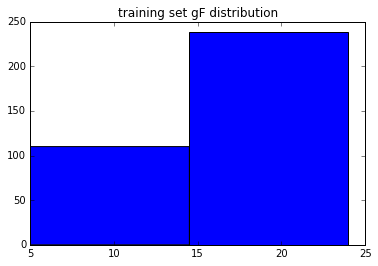

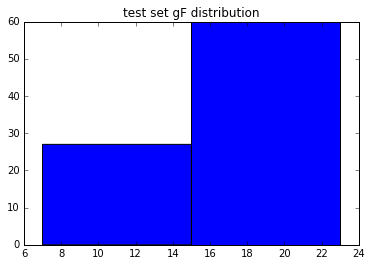

In [13]:
# Hold out set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(edges,gF,test_size=0.2, random_state=42, stratify=bins)
test_bins = np.digitize(y_test, bin_limits[:-1])
train_bins = np.digitize(y_train, bin_limits[:-1])

plt.hist(y_train, bins=n_bins)
plt.title('training set gF distribution')
plt.show()
plt.hist(y_test, bins=n_bins)
plt.title('test set gF distribution')
plt.show()

In [14]:
errors_c = np.zeros([len(y_test)])
errors_r = np.zeros([len(y_test)])
predictions_c = np.zeros([len(y_test)])
predictions_r = np.zeros([len(y_test)])
#estimator = OneVsRestClassifier(LinearSVC(random_state=0))
estimator = LinearSVC(random_state=0)
pca = PCA(n_components=0.999)
k=5
n_bins_cv = 2

# decomposition
data_pc = pca.fit_transform(X_train)

# classification
estimator.fit(data_pc,train_bins)
predictions_c = estimator.predict(pca.transform(X_test))
errors_c = predictions_c==test_bins

# regressor for class 1
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==1], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==1], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
#cv = cross_validation.KFold(k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==1,],y_train[train_bins==1])
predictions_r[predictions_c==1] = lasso.predict(X_test[predictions_c==1])
errors_r[test_bins==1] = abs(predictions_r[test_bins==1]-y_test[test_bins==1])

# regressor for class 2
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==2], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==2], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==2,],y_train[train_bins==2])
predictions_r[predictions_c==2] = lasso.predict(X_test[predictions_c==2])      
errors_r[test_bins==2] = abs(predictions_r[test_bins==2]-y_test[test_bins==2])



C:\Users\Paola\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [16]:
print(predictions_r)

[ 19.322294    19.01522167  19.77912626  10.73636364  20.40935917
  19.30616907  19.93841357  10.73636364  19.03177296  19.04494765
  10.73636364  10.73636364  19.87433107  20.55652168  19.23454413
  19.36181652  10.73636364  10.73636364  18.93892366  20.58466351
  19.51562007  18.98916885  19.41736325  19.76923772  20.10100903
  19.40851404  10.73636364  19.22277643  10.73636364  19.36156509
  19.77047393  18.76534125  20.16051397  10.73636364  10.73636364
  10.73636364  20.03383038  19.01093313  19.86173201  19.18725181
  19.40964205  20.28112823  19.53723207  19.66685988  20.21605318
  10.73636364  10.73636364  18.91695245  10.73636364  19.68846158
  19.52626571  19.68034536  20.02878663  10.73636364  10.73636364
  19.06520594  10.73636364  19.61875082  19.19607683  19.57087256
  10.73636364  19.40917566  19.68900163  19.603279    19.64964352
  10.73636364  19.63277518  19.57430424  19.31110434  19.30760597
  10.73636364  19.34167187  18.84528409  19.56919179  19.47315834
  18.85372

The probabilities given in output by the classifier are used as weights to compute a linear combination of the output of the two regressors

In [17]:
errors_c = np.zeros([len(y_test)])
errors_r1 = np.zeros([len(y_test)])
errors_r2 = np.zeros([len(y_test)])
predictions_c = np.zeros([len(y_test)])
predictions_r1 = np.zeros([len(y_test)])
predictions_r2 = np.zeros([len(y_test)])
prob = np.zeros([len(y_test),2])

#estimator = OneVsRestClassifier(LinearSVC(random_state=0))
#estimator = LinearSVC(random_state=0)
estimator = SVC(kernel='linear',probability=True,random_state=0)
pca = PCA(n_components=0.999)
k=5
n_bins_cv = 2

# decomposition
data_pc = pca.fit_transform(X_train)

# classification
estimator.fit(data_pc,train_bins)
predictions_c = estimator.predict(pca.transform(X_test))
prob = estimator.predict_proba(pca.transform(X_test))
errors_c = predictions_c==test_bins

# regressor for class 1
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==1], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==1], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==1,],y_train[train_bins==1])
predictions_r1 = lasso.predict(X_test)
errors_r1 = abs(predictions_r1-y_test)

# regressor for class 2
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==2], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==2], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==2,],y_train[train_bins==2])
predictions_r2 = lasso.predict(X_test)      
errors_r2 = abs(predictions_r2-y_test)

final_preds = prob[:,0]*predictions_r1 + prob[:,1]*predictions_r2



C:\Users\Paola\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [18]:
#data_ext
print(final_preds)

[ 17.03534863  17.22522184  17.83872364  15.44909558  17.23655112
  17.22797719  16.69227094  15.48863418  16.57187407  16.95579411
  16.03724469  15.93780972  16.63023899  18.82883834  16.66319206
  17.24921791  15.8234867   16.57685084  17.27025141  17.82079129
  16.69520003  16.47565803  16.84707483  17.38379335  18.259516
  17.14495822  16.04419291  16.88998663  15.98411632  17.79360605
  17.20762041  17.2872317   18.00016116  16.37529722  15.89266394
  15.82853403  17.53168009  16.85090787  16.88955702  16.40024003
  17.21206216  17.48629187  17.61098921  16.77267085  17.58321241
  16.26924346  15.24401591  17.47069877  16.09039274  17.85099454
  16.67810436  17.83863284  18.62696375  15.64885678  15.76320586
  16.11823987  15.17242119  17.76053072  16.62414565  17.52127271
  15.5814174   16.65901763  17.46205228  16.79035212  16.60117151
  16.43006588  17.70168792  17.09724079  16.71845268  17.37399254
  16.23989273  17.63829656  16.41932638  17.04667086  17.60571559
  17.4382084

In [60]:
#Rest2
print(final_preds)
print(y_test)

[ 16.78817621  16.79449873  16.16698028  16.32242964  16.50318109
  16.72517111  17.12017499  16.77752074  16.79746662  16.44549997
  16.62491928  17.46759334  16.8149031   16.63513961  16.38139242
  16.44757554  16.6544701   16.97434174  16.90784355  16.69727397
  16.66907056  16.60802469  16.92485291]
[19 16 20  7 21 18 20 23 15 10 20 19 13 16 18 21 20 20 19  7 22 12  6]


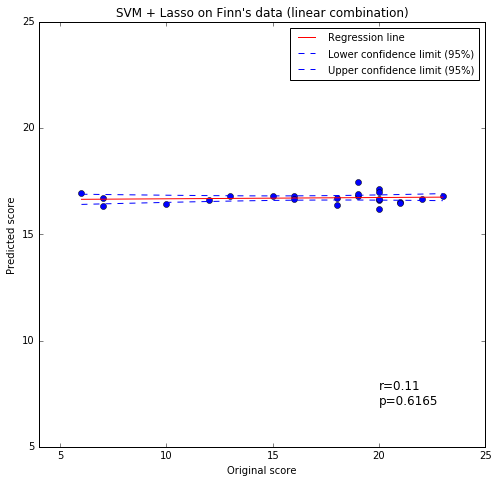

In [59]:
regression_plot(np.ravel(y_test),final_preds,len(y_test),'SVM + Lasso on Finn\'s data (linear combination)')

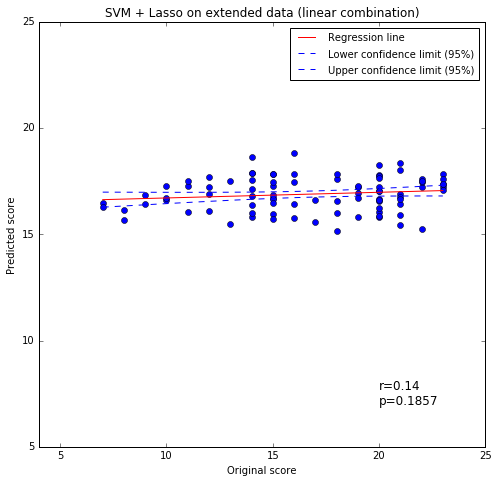

In [19]:
regression_plot(np.ravel(y_test),final_preds,len(y_test),'SVM + Lasso on extended data (linear combination)')

In [ ]:
regression_plot(np.ravel(y_test),final_preds,len(y_test),'SVM + Lasso on Finn\'s data (linear combination)')

#### Preliminary test
In order to evaluate the performance of the double regression, an oracle is used instead of the classifier

In [11]:
errors_r = np.zeros([len(y_test)])
predictions_r = np.zeros([len(y_test)])

k=5
n_bins_cv = 2

# regressor for class 1
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==1], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==1], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
#cv = cross_validation.KFold(k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==1,],y_train[train_bins==1])
predictions_r[test_bins==1] = lasso.predict(X_test[test_bins==1])
errors_r[test_bins==1] = abs(predictions_r[test_bins==1]-y_test[test_bins==1])

# regressor for class 2
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==2], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==2], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==2,],y_train[train_bins==2])
predictions_r[test_bins==2] = lasso.predict(X_test[test_bins==2])      
errors_r[test_bins==2] = abs(predictions_r[test_bins==2]-y_test[test_bins==2])



In [67]:
print(confusion_matrix(test_bins, predictions_c))
print('Mean regression error:',errors_r.mean())

[[ 1  5]
 [ 1 16]]
Mean regression error: 3.87123911479


In [12]:
print('Mean regression error:',errors_r.mean())

Mean regression error: 1.93646968231


In [14]:
print(predictions_r)

[ 19.32678708  19.69442632  17.95923211  11.93222149  19.86805903
  18.66479361  19.28390395  19.3842552   20.07267152  10.36669783
  19.18010019  19.76105205  11.08494866  19.03395738  19.52445776
  19.50400842  19.85424396  19.51400362  20.14663027  10.18809713
  19.21307972  11.94585248  10.61869759]


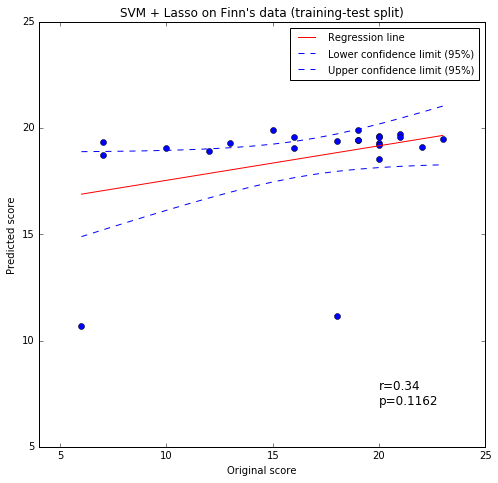

In [43]:
regression_plot(np.ravel(y_test),predictions_r,len(y_test),'SVM + Lasso on Finn\'s data (training-test split)')

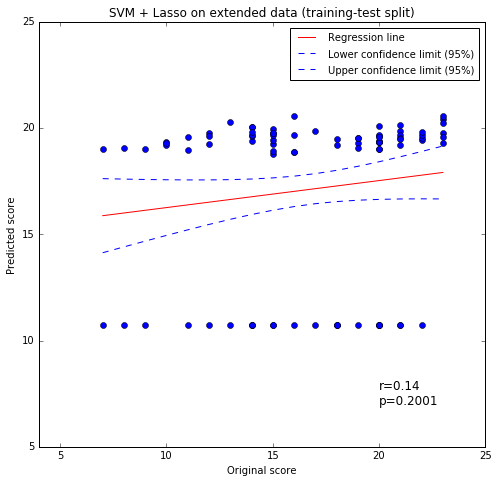

In [15]:
regression_plot(np.ravel(y_test),predictions_r,len(y_test),'SVM + Lasso on extended data (training-test split)')

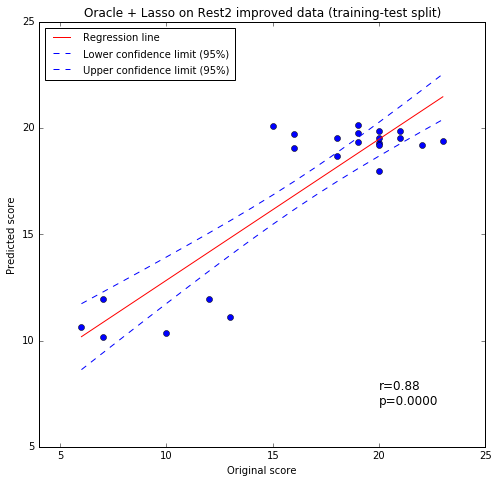

In [13]:
regression_plot(np.ravel(y_test),predictions_r,len(y_test),'Oracle + Lasso on Rest2 improved data (training-test split)')

Classification and regression with leave-one-out require much more time and I still have to select the final model

In [38]:
loo = cross_validation.LeaveOneOut(len(y_train))
errors_c = np.zeros([len(y_train),1])
errors_r = np.zeros([len(y_train),1])
predictions_c = np.zeros([len(y_train),1])
predictions_r = np.zeros([len(y_train),1])
estimator = OneVsRestClassifier(LinearSVC(random_state=0))
pca = PCA(n_components=0.999)
k=5
n_bins_cv = 4

i=0
f = FloatProgress(min=0, max=len(y_train))
display(f)
for train_index, test_index in loo:
    # decomposition
    data_pc = pca.fit_transform(X_train[train_index,])
    # regression
    estimator.fit(data_pc,bins[train_index])
    predictions_c[i] = estimator.predict(pca.transform(X_train[test_index,]))

    errors_c[i] = 1 if predictions[i]==bins[test_index] else 0
    i += 1
    f.value += 1
        
print('Accuracy:',errors_c.mean())
preds_5 = predictions


Accuracy: 0.692307692308


In [39]:
confusion_matrix(bins, preds_5)

array([[ 2, 24],
       [ 4, 61]])

In [ ]:
# TODO: merge to above cell
k=5
n_bins_cv = 4

f = FloatProgress(min=0, max=len(y_train))
display(f)
for train_index, test_index in loo:
    hist_cv, bin_limits_cv = np.histogram(y_train[train_index], n_bins_cv)
    bins_cv = np.digitize(y_train[train_index], bin_limits_cv[:-1])
    cv = cross_validation.StratifiedKFold(bins_cv,k)
    lasso = LassoCV(cv=cv,n_jobs=-1)
    lasso.fit(X_train[train_index,],y_train[train_index])
    predictions_r = lasso.predict(X_train[test_index,])
    errors_r[i] = abs(predictions[i]-y_train[test_index])

print('Mean error:',errors_r.mean())